In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import quant

## Verify corectness

In [2]:
# Verify various values for M to ensure correctness with all kinds of context lengths
for M in [8, 100, 256, 2048]:
	M = M # B * seq_len
	K = 4096 # Input dimension
	N = 4096 # Output dimension

	torch.manual_seed(0)
	layer = nn.Linear(K, N)
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cudalayer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cudalayer.pack(layer, quantizer.scale, quantizer.zero)

	tritonlayer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	state_dict = cudalayer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	tritonlayer.load_state_dict(state_dict)

	layer = layer.half()

	layer = layer.to('cuda')
	cudalayer = cudalayer.to('cuda')
	tritonlayer = tritonlayer.to('cuda')

	ref = layer(vec)
	cuda_out = cudalayer(vec)
	triton_out = tritonlayer(vec)

	print(f'[{M}, {K}] -> [{M}, {N}]')
	print(f'cuda_out - ref: {(cuda_out - ref).abs().max()}')
	print(f'triton_out - ref: {(triton_out - ref).abs().max()}')
	print(f'triton_out - cuda_out: {(triton_out - cuda_out).abs().max()}')

[8, 4096] -> [8, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.001953125
triton_out - cuda_out: 0.001953125
[100, 4096] -> [100, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.001953125
[256, 4096] -> [256, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.001953125
[2048, 4096] -> [2048, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.00390625


## Benchmark Kernel

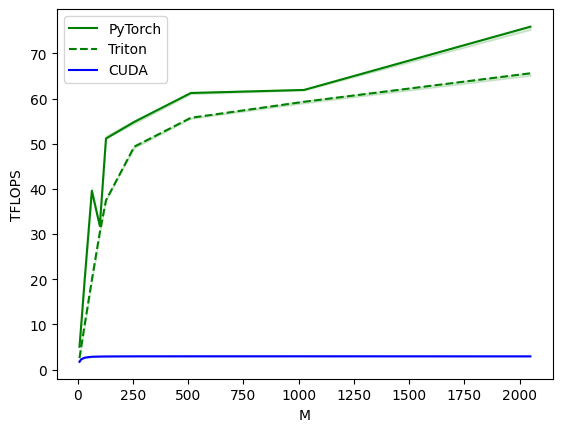

matmul:
         M    PyTorch     Triton      CUDA
0      8.0   5.041231   2.545087  1.713359
1     10.0   6.182642   3.150769  1.883218
2     16.0   9.892226   5.041231  2.259862
3     32.0  20.164923   9.986438  2.634613
4     64.0  39.568906  19.784453  2.822546
5    100.0  31.813593  30.340741  2.871867
6    128.0  51.150050  37.449142  2.892623
7    256.0  54.827503  49.344753  2.922860
8    512.0  61.230717  55.738260  2.928728
9   1024.0  61.908547  59.283449  2.932054
10  2048.0  75.915006  65.600063  2.916382


In [3]:
@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			8, 10, 16, 32, 64, 100, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	layer = nn.Linear(4096, 4096)
	vec = torch.randn(M, 4096, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	triton_layer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * 4096 * 4096 * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)